In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from typing import *
import numpy as np
from functools import partial
from fastprogress import progress_bar
import pandas as pd
import h5py

from lumin.plotting.results import plot_roc

import torch
from torch import Tensor, nn
import torch.nn.functional as F
from torch._vmap_internals import _vmap as vmap

from tomopt.volume import *
from tomopt.muon import *
from tomopt.inference import *
from tomopt.optimisation import *
from tomopt.core import *
from tomopt.utils import *
from tomopt.plotting import *

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
DEVICE = torch.device("cpu")

In [4]:
def area_cost(x:Tensor) -> Tensor:
    return F.relu(x)

In [5]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 1.0
    init_res = 1e4
    n_panels = 4
    layers.append(PanelDetectorLayer(pos='above', lw=lwh[:2], z=1, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,1-(i*(2*size)/n_panels)], init_xy_span=[1.0,1.0] if i in [0,3] else [0.5,0.5],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))
    for z in [0.8,0.7,0.6,0.5,0.4,0.3]:
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
    layers.append(PanelDetectorLayer(pos='below', lw=lwh[:2], z=0.2, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,0.2-(i*(2*size)/n_panels)], init_xy_span=[1.0,1.0] if i in [0,3] else [0.5,0.5],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))

    return nn.ModuleList(layers) 

In [6]:
volume = Volume(get_layers())

In [7]:
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.]), and xy span tensor([1., 1.])
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9500]), and xy span tensor([0.5000, 0.5000])
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9000]), and xy span tensor([0.5000, 0.5000])
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.8500]), and xy span tensor([1., 1.])
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): PassiveLayer()
    (6): PassiveLayer()
    (7): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=t

In [8]:
def sig_rad_length(*,z:float, lw:Tensor, size:float) -> Tensor:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z > 0.4 and z <= 0.5: rad_length[7:,6:] = X0['uranium']
    return rad_length

In [9]:
def bkg_rad_length(*,z:float, lw:Tensor, size:float) -> Tensor:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    return rad_length

# Build dataset

In [10]:
def get_preds(volume:Volume) -> Tensor:
    gen = MuonGenerator2016.from_volume(volume)
    mus = MuonResampler.resample(gen(250), volume=volume, gen=gen)
    mu = MuonBatch(mus, init_z=volume.h)
    volume(mu)
    
    sb = PanelScatterBatch(mu, volume)
    inf = PanelX0Inferer(volume)
    inf.add_scatters(sb)
    vox_preds, weights = inf.get_prediction()
    return vox_preds

In [ ]:
sigs, bkgs = [], []
for i in progress_bar(range(100)):
    volume.load_rad_length(sig_rad_length)
    sigs.append(get_preds(volume).detach())
    volume.load_rad_length(bkg_rad_length)
    bkgs.append(get_preds(volume).detach())

In [ ]:
sig = torch.stack(sigs)
bkg = torch.stack(bkgs)

In [ ]:
with h5py.File('bimodal_data_1e4.hdf5', "w") as outfile:
    outfile.create_dataset('sig', data=sig, compression='lzf')
    outfile.create_dataset('bkg', data=bkg, compression='lzf')

In [11]:
with h5py.File('bimodal_data_1e4.hdf5', "r") as infile:
    sig = Tensor(infile['sig'][()])
    bkg = Tensor(infile['bkg'][()])
data = torch.cat([sig, bkg], dim=0)

# Vars

In [12]:
stargs = torch.ones(len(sig))
btargs = torch.zeros(len(bkg))

In [13]:
sig = pd.DataFrame(stargs, columns=['gen_target'])
bkg = pd.DataFrame(btargs, columns=['gen_target'])
df = sig.append(bkg, ignore_index=True)

## Simple ranking

In [14]:
def lowest_frac(vox_preds:Tensor, frac:float = 12/600) -> Tensor:
    cut = vox_preds.view(-1).kthvalue(1+round(frac*(vox_preds.numel()-1))).values
    return vox_preds.mean()-vox_preds[vox_preds<cut].mean()

In [15]:
df['lowest_frac'] = torch.stack([lowest_frac(d) for d in data.unbind()])

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


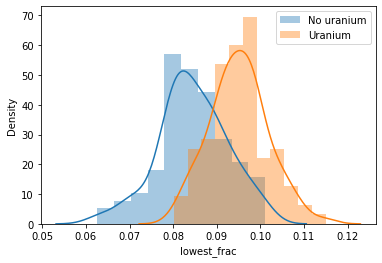

In [16]:
sns.distplot(df.loc[df.gen_target == 0, 'lowest_frac'], label='No uranium')
sns.distplot(df.loc[df.gen_target == 1, 'lowest_frac'], label='Uranium')
plt.legend()

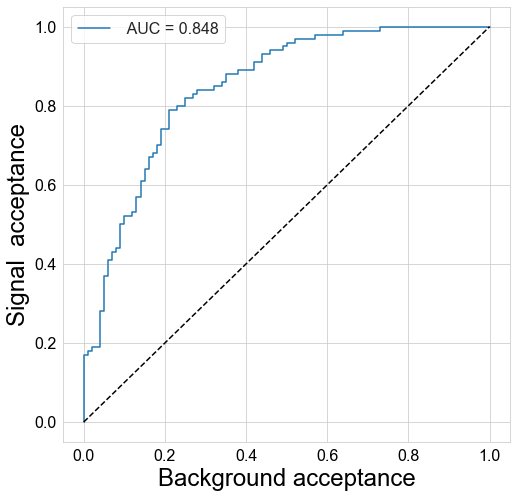

{'': 0.8484}

In [17]:
plot_roc(df, pred_name='lowest_frac')

## Simple ranking + pooling

### Avg

In [18]:
from tomopt.plotting.appearance import *

def plot_pred(pred):
    with sns.axes_style(style="whitegrid", rc={"patch.edgecolor": "none"}):
        fig, axs = plt.subplots(1, len(pred), figsize=(W_MID, H_MID))

        for i in range(len(pred)):
            sns.heatmap(
                pred[i],
                ax=axs[i],
                cmap="viridis",
                square=True,
                cbar=False,
                vmin=np.nanmin(pred),
                vmax=np.nanmax(pred),
            )
        plt.show()

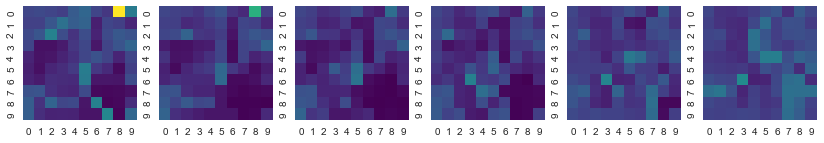

In [19]:
plot_pred(data[0])

In [20]:
data[:,None].shape

torch.Size([200, 1, 6, 10, 10])

In [21]:
F.avg_pool3d(data[:,None], kernel_size=3, stride=1, padding=1).shape

torch.Size([200, 1, 6, 10, 10])

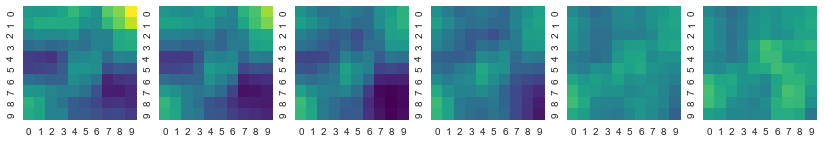

In [22]:
plot_pred(F.avg_pool3d(data[:,None], kernel_size=3, stride=1, padding=1, count_include_pad=False)[0,0])

In [23]:
avgdata = F.avg_pool3d(data[:,None], kernel_size=3, stride=1, padding=1, count_include_pad=False)[:,0]
df['lowest_frac_avgpool'] = torch.stack([lowest_frac(d) for d in avgdata.unbind()])

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


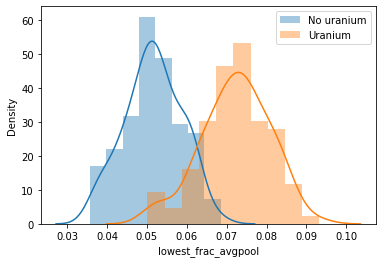

In [24]:
sns.distplot(df.loc[df.gen_target == 0, 'lowest_frac_avgpool'], label='No uranium')
sns.distplot(df.loc[df.gen_target == 1, 'lowest_frac_avgpool'], label='Uranium')
plt.legend()

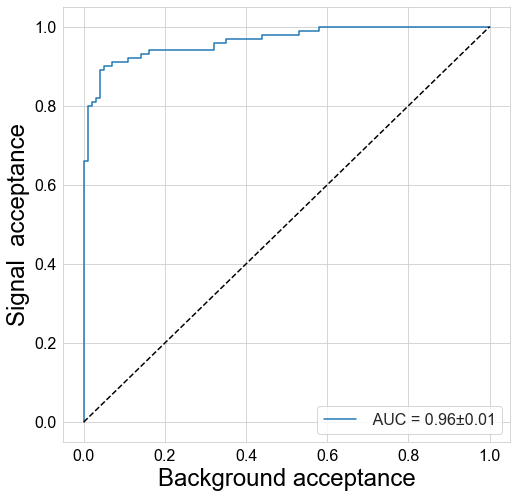

{'': (0.9644261333796637, 0.01124501568502514)}

In [25]:
plot_roc(df, pred_name='lowest_frac_avgpool', n_bootstrap=100)

### Max

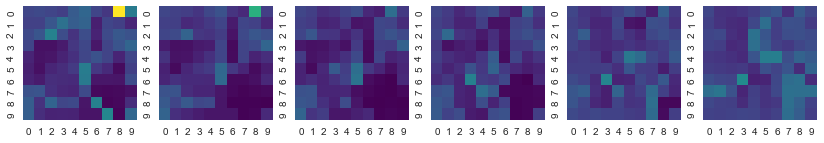

In [26]:
plot_pred(data[0])

In [27]:
data[:,None].shape

torch.Size([200, 1, 6, 10, 10])

In [28]:
F.avg_pool3d(data[:,None], kernel_size=3, stride=1, padding=1).shape

torch.Size([200, 1, 6, 10, 10])

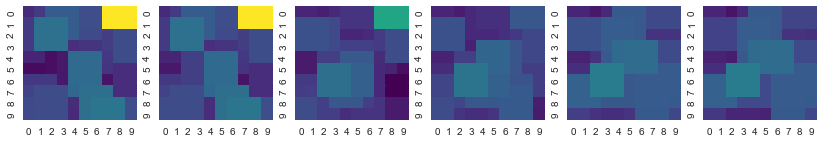

In [29]:
plot_pred(F.max_pool3d(data[:,None], kernel_size=3, stride=1, padding=1)[0,0])

In [30]:
maxdata = F.max_pool3d(data[:,None], kernel_size=3, stride=1, padding=1)[:,0]
df['lowest_frac_maxpool'] = torch.stack([lowest_frac(d) for d in maxdata.unbind()])

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


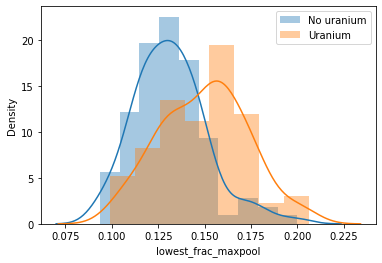

In [31]:
sns.distplot(df.loc[df.gen_target == 0, 'lowest_frac_maxpool'], label='No uranium')
sns.distplot(df.loc[df.gen_target == 1, 'lowest_frac_maxpool'], label='Uranium')
plt.legend()

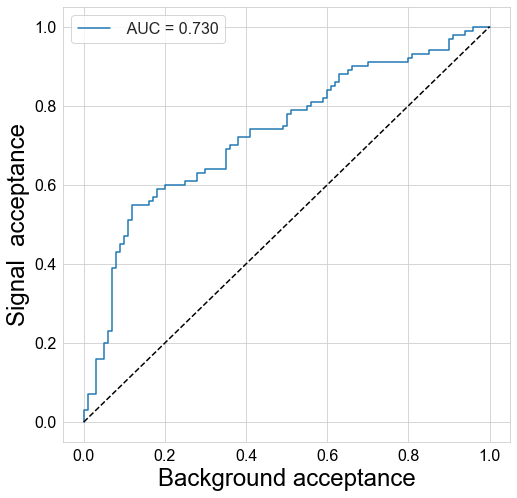

{'': 0.7301}

In [32]:
plot_roc(df, pred_name='lowest_frac_maxpool')

## Simple ranking + pooling + better diff

In [34]:
def lowest_frac_diff(vox_preds:Tensor, frac:float = 12/600) -> Tensor:
    cut = vox_preds.view(-1).kthvalue(1+round(frac*(vox_preds.numel()-1))).values
    return vox_preds[vox_preds>=cut].mean()-vox_preds[vox_preds<cut].mean()

In [35]:
df['lowest_frac_diff'] = torch.stack([lowest_frac_diff(d) for d in avgdata.unbind()])

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


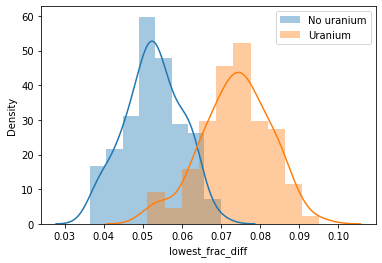

In [36]:
sns.distplot(df.loc[df.gen_target == 0, 'lowest_frac_diff'], label='No uranium')
sns.distplot(df.loc[df.gen_target == 1, 'lowest_frac_diff'], label='Uranium')
plt.legend()

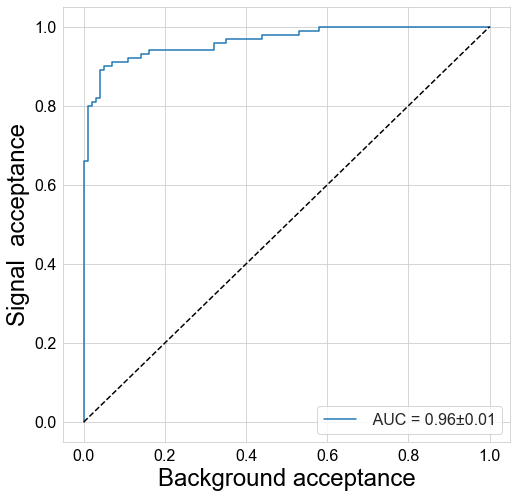

{'': (0.9617439210632637, 0.012945626607668355)}

In [37]:
plot_roc(df, pred_name='lowest_frac_diff', n_bootstrap=100)

## Simple ranking + pooling + better diff + ratio

In [207]:
def lowest_frac_diff_ratio(vox_preds:Tensor, frac:float = 12/600) -> Tensor:
    cut = vox_preds.view(-1).kthvalue(1+round(frac*(vox_preds.numel()-1))).values
    a = vox_preds[vox_preds>=cut].mean()
    b = vox_preds[vox_preds<cut].mean()
    r = 2*(a-b)/(a+b)
    return F.sigmoid((r-1)*1)

In [208]:
df['lowest_frac_diff_ratio'] = torch.stack([lowest_frac_diff_ratio(d) for d in avgdata.unbind()])

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


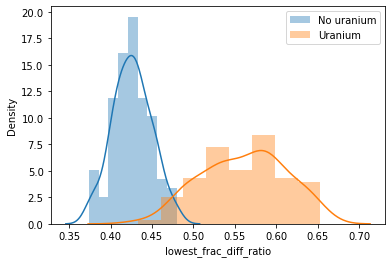

In [209]:
sns.distplot(df.loc[df.gen_target == 0, 'lowest_frac_diff_ratio'], label='No uranium')
sns.distplot(df.loc[df.gen_target == 1, 'lowest_frac_diff_ratio'], label='Uranium')
plt.legend()

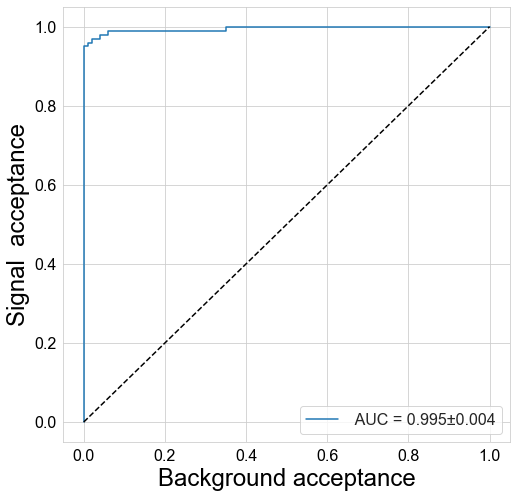

{'': (0.9946547153540064, 0.003929433141614476)}

In [203]:
plot_roc(df, pred_name='lowest_frac_diff_ratio', n_bootstrap=100)

## Max-Min

In [136]:
def max_min(vox_preds:Tensor) -> Tensor:
    return vox_preds.max()-vox_preds.min()

In [137]:
max_min(data[0])

tensor(0.6005)

In [190]:
df['max_min'] = torch.stack([max_min(d) for d in avgdata.unbind()])

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


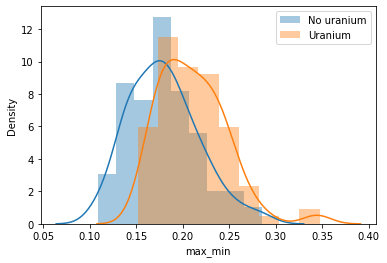

In [191]:
sns.distplot(df.loc[df.gen_target == 0, 'max_min'], label='No uranium')
sns.distplot(df.loc[df.gen_target == 1, 'max_min'], label='Uranium')
plt.legend()

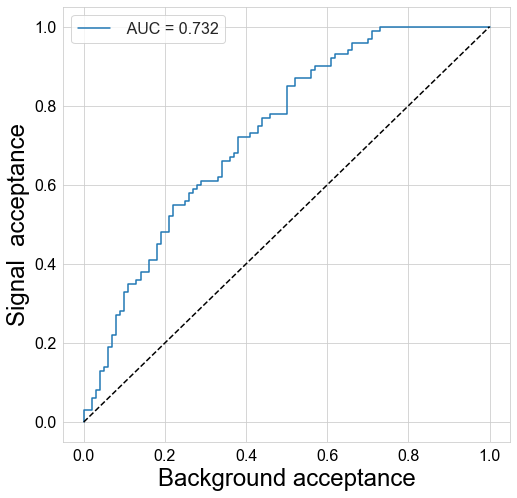

{'': 0.7318}

In [192]:
plot_roc(df, pred_name='max_min')

## Maxfrac-Minfrac

In [193]:
def lowest_highest_frac(vox_preds:Tensor, frac:float = 12/600) -> Tensor:
    lowcut = vox_preds.view(-1).kthvalue(1+round(frac*(vox_preds.numel()-1))).values
    highcut = vox_preds.view(-1).kthvalue(1+round((1-frac)*(vox_preds.numel()-1))).values
    
    return vox_preds[vox_preds>=highcut].mean()-vox_preds[vox_preds<lowcut].mean()

In [194]:
lowest_highest_frac(data[0])

tensor(0.2947)

In [195]:
df['lowest_highest_frac'] = torch.stack([lowest_highest_frac(d) for d in avgdata.unbind()])

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


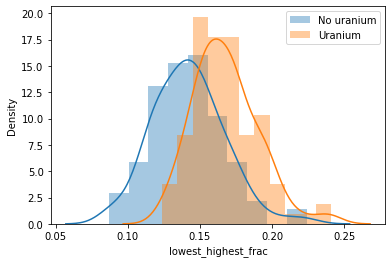

In [196]:
sns.distplot(df.loc[df.gen_target == 0, 'lowest_highest_frac'], label='No uranium')
sns.distplot(df.loc[df.gen_target == 1, 'lowest_highest_frac'], label='Uranium')
plt.legend()

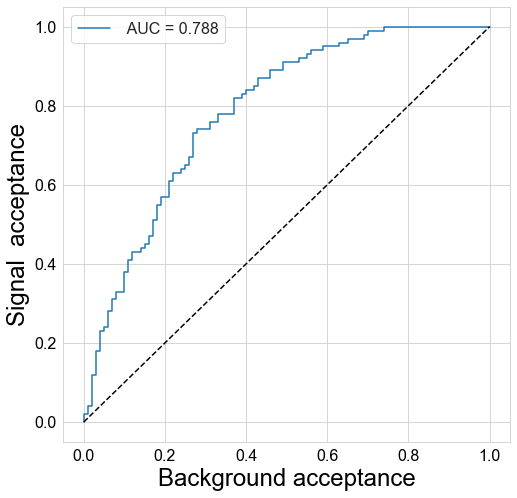

{'': 0.7876000000000001}

In [197]:
plot_roc(df, pred_name='lowest_highest_frac')